A notebook to preprocess Cascadia catalogs: project event along-strike, estimate tremor depth, trim catalogs in time and space, count earthquakes around tremor, in different magnitude and distance bins.

**Table of contents**<a id='toc0_'></a>    
- 1. [Load data               ](#toc1_)    
  - 1.1. [Load earthquake catalog               ](#toc1_1_)    
  - 1.2. [Load original tremor and model depth             ](#toc1_2_)    
  - 1.3. [Map it            ](#toc1_3_)    
- 2. [Project along-strike      ](#toc2_)    
- 3. [Trim catalogs          ](#toc3_)    
- 4. [Measure distance earthquakes-tremor distance   ](#toc4_)    
- 5. [Count number of earthquakes "felt" by tremor             ](#toc5_)    
- 6. [Inspect results ](#toc6_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [2]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd

from scipy.spatial import cKDTree

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

import os
# if my user name is gafarge then use the following path
if os.getlogin() == 'gafarge':
    workdir = '/home/gafarge/'
elif os.getlogin() == 'root':
    workdir = '/Users/gaspard/Documents/work/'

# 1. <a id='toc1_'></a>Load data                [&#128285;](#toc0_)

In [3]:
# Constants
day0 = np.datetime64('2009-08-01')
minlat = 39
maxlat = 52
minlon = -128
maxlon = -121

## 1.1. <a id='toc1_1_'></a>Load earthquake catalog                [&#128285;](#toc0_)

In [4]:
# Load earthquakes
path = workdir + "projects/data/Catalogs/cascadia_eq_anss_0924/cascadia_eq_anss_0924.csv"
eq = pd.read_csv(path, parse_dates=['time'])

# Rename columns
eq.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'time': 'date'}, inplace=True)

# Sort by date
eq.sort_values('date', inplace=True)

# Keep only data that we are using
eq.drop(['magType', 'nst', 'dmin', 'rms', 'updated', 'place', 'type', 'horizontalError', 'depthError', 'magError', 'magNst', 'status', 'locationSource', 'magSource', 'net', 'gap', 'id'], axis=1, inplace=True)

## 1.2. <a id='toc1_2_'></a>Load original tremor and model depth              [&#128285;](#toc0_)

In [5]:
# Load original tremor catalog
path = workdir + "projects/data/Catalogs/cascadia_tremor/cascadia_tremor_0809_0624.csv"
trm = pd.read_csv(path, parse_dates=['starttime'], low_memory=False)

# Rename columns
trm.rename(columns={'latitude': 'lat', 'longitude': 'lon', 'starttime': 'date'}, inplace=True)

# Sort by date
trm.sort_values('date', inplace=True)

# Remove columns energy and duration
trm.drop(columns=['duration '], inplace=True)

In [6]:
# Load slab
path = workdir + "projects/data/Slabs/cascadia/cascadia_slab_bostock19/cascadia_slab_bostock19.csv"
slab = pd.read_csv(path, names=['lat', 'lon', 'depth'], sep=' ')

In [7]:
# Project tremor onto slab: find nearest neighbor
# --> Convert to cartesian coordinates
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(crs, trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(crs, eq.lon.values, eq.lat.values)
slab_coords = crs.transform_points(crs, slab.lon.values, slab.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000
slab.loc[:, 'x'] = slab_coords[:, 0]/1000
slab.loc[:, 'y'] = slab_coords[:, 1]/1000

# --> Find nearest neighbor
tree = cKDTree(slab[['x', 'y']].values)
dist, idx = tree.query(trm[['x', 'y']].values)
trm['depth'] = slab.loc[idx, 'depth'].values

## 1.3. <a id='toc1_3_'></a>Map it             [&#128285;](#toc0_)

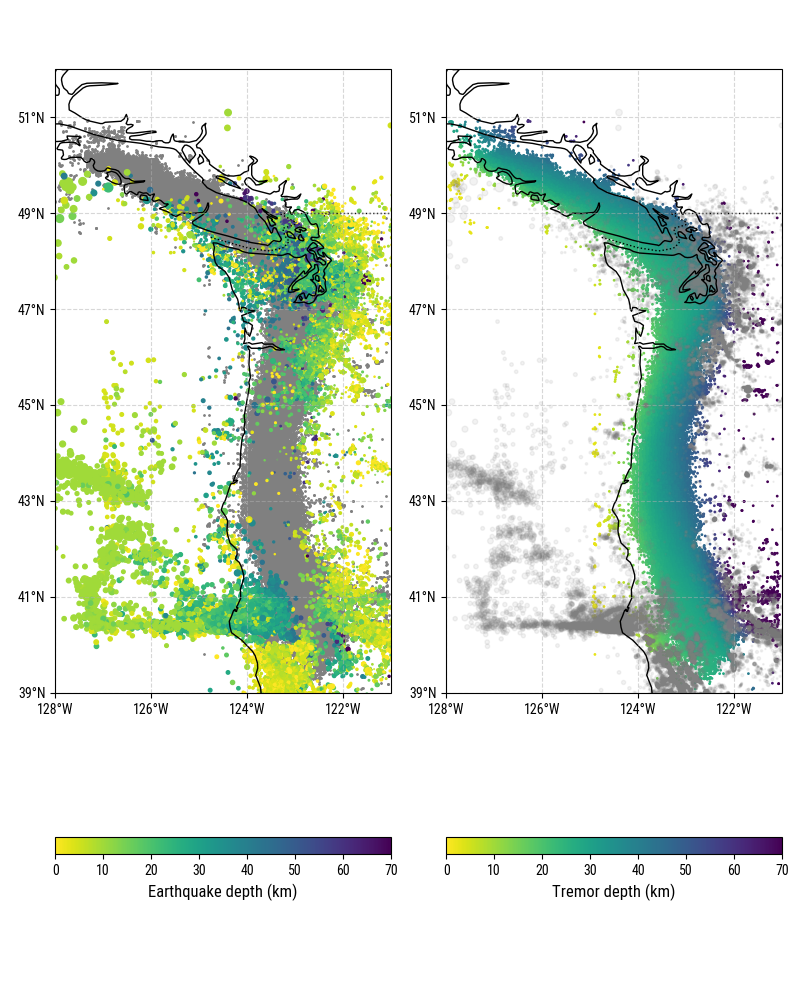

In [8]:
# Plot it
fig = plt.figure(figsize=(8, 10))
axes = [fig.add_subplot(121, projection=ccrs.PlateCarree()), fig.add_subplot(122, projection=ccrs.PlateCarree())]

for ax in axes:
    ax.set_extent([minlon, maxlon, minlat, maxlat])
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.BORDERS, linestyle=':')

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(minlon, maxlon, 2))
    ax.set_yticks(np.arange(minlat, maxlat, 2))
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)


# Plot earthquakes and tremor
sc = axes[0].scatter(eq.lon, eq.lat, s=eq.mag**2, c=eq.depth, cmap='viridis_r', transform=ccrs.PlateCarree(), vmin=0, vmax=70)
axes[0].scatter(trm.lon, trm.lat, s=1, c='.5', transform=ccrs.PlateCarree(), zorder=-1)
cbar = plt.colorbar(sc, ax=axes[0], orientation='horizontal', label='Earthquake depth (km)')

axes[1].scatter(eq.lon, eq.lat, s=eq.mag**2, c=[to_rgba('.5', .1) for ii in range(len(eq))],transform=ccrs.PlateCarree())
sc = axes[1].scatter(trm.lon, trm.lat, s=1, c=trm.depth, transform=ccrs.PlateCarree(), zorder=-1, cmap='viridis_r', vmin=0, vmax=70)
cbar = plt.colorbar(sc, ax=axes[1], orientation='horizontal', label='Tremor depth (km)')

plt.tight_layout()
plt.show()

# 2. <a id='toc2_'></a>Project along-strike       [&#128285;](#toc0_)

In [9]:
# Get cartesian coordinates for everyone
crs = ccrs.TransverseMercator(central_longitude=trm.lon.mean(), central_latitude=trm.lat.mean())

trm_coords = crs.transform_points(ccrs.PlateCarree(), trm.lon.values, trm.lat.values)
eq_coords = crs.transform_points(ccrs.PlateCarree(), eq.lon.values, eq.lat.values)

trm.loc[:, 'x'] = trm_coords[:, 0]/1000  # x is easting (km)
trm.loc[:, 'y'] = trm_coords[:, 1]/1000  # y is northing (km)
eq.loc[:, 'x'] = eq_coords[:, 0]/1000
eq.loc[:, 'y'] = eq_coords[:, 1]/1000

In [10]:
# Define along-strike: fit a polynomial to the tremor line
# We will have work with y (longitudinal coordinate) as a function of x
p_strike = np.polyfit(trm.y, trm.x, 4)

# Project along-strike: nearest point from each event to the strike line
# --> Define a strike line with evenly spaced points along it
y0, x0 = -700, np.polyval(p_strike, -700)   # initial point
ds = .01 # spacing along the curve in km

X, Y = [], []  # initialize the location of the points along the line
X.append(x0)
Y.append(y0)
y = y0
while y < 700:
    # Using the arc-length formula, we can find the dy to the next point,
    # and then using the polynomial, we can find the corresponding x.
    dy = ds / np.sqrt(1 + (np.polyval(np.polyder(p_strike), y))**2)
    y += dy
    x = np.polyval(p_strike, y)
    X.append(x)
    Y.append(y)

S = np.cumsum(np.ones(len(X)) * ds) - ds  # along-strike distance for each (X, Y)

# --> Find nearest neighbor — but the distance matrix is huge, so make a tree of the strike points 
# to have a rough first guess before computing the nearest neighbor
from scipy.spatial import cKDTree

tree = cKDTree(np.column_stack((Y, X)))
eq_across_strike_dist, eq_nearest_idx = tree.query(np.column_stack((eq.y, eq.x)))
trm_across_strike_dist, trm_nearest_idx = tree.query(np.column_stack((trm.y, trm.x)))

eq_along_strike_dist = S[eq_nearest_idx]
trm_along_strike_dist = S[trm_nearest_idx]

eq['xf'] = eq_along_strike_dist  # xf or xfault: along-strike distance in km
eq['yf'] = eq_across_strike_dist  # yf or yfault: across-strike distance in km
trm['xf'] = trm_along_strike_dist
trm['yf'] = trm_across_strike_dist

# # Show
# fig, axes = plt.subplots(2, 1, figsize=(10, 10))
# for ax in axes:
#     ax.set_aspect('equal')
#     ax.set_xlabel('y (km)')  
#     ax.set_ylabel('x (km)')
#     ax.plot(Y, X, 'r', zorder=10)

# axes[0].scatter(eq.y, eq.x, s=eq.mag**3, c=eq_along_strike_dist, ec='k', cmap='viridis', vmin=0, vmax=1500)
# axes[0].scatter(trm.y, trm.x, s=1, c=trm_along_strike_dist, cmap='viridis', vmin=0, vmax=1500)

# axes[1].scatter(eq.y, eq.x, s=eq.mag**3, c=eq_across_strike_dist, ec='k', cmap='viridis')
# axes[1].scatter(trm.y, trm.x, s=1, c=trm_across_strike_dist, cmap='viridis')

# plt.tight_layout()
# plt.show()

In [11]:
# A better origin for along-strike position
xf_origin = trm.xf.min()
trm.xf = trm.xf - xf_origin
eq.xf = eq.xf - xf_origin

In [12]:
# Save along-strike line
along_strike_coords = ccrs.PlateCarree().transform_points(crs, np.array(X)*1000, np.array(Y)*1000)

along_strike_lon = along_strike_coords[:, 0]
along_strike_lat = along_strike_coords[:, 1]

along_strike = {'x': X, 'y': Y, 's': S-xf_origin, 'lon': along_strike_lon, 'lat': along_strike_lat}

# save with pickle
import pickle
path = 'data/cascadia/processed/cascadia_along_strike.pkl'
with open(path, 'wb') as f:
    pickle.dump(along_strike, f)

# 3. <a id='toc3_'></a>Trim catalogs           [&#128285;](#toc0_)

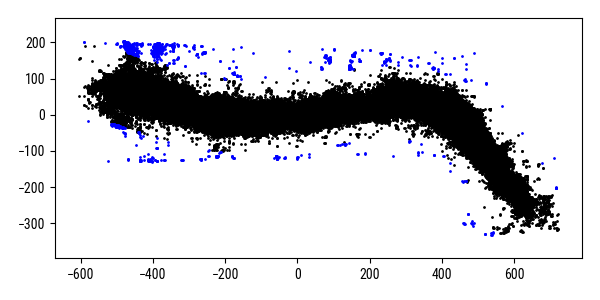

In [13]:
# In space, using across_strike distance
max_dist = 100
fig, ax = plt.subplots(figsize=(6,3))
ax.axis('equal')
ax.scatter(trm.y[(trm.yf < max_dist)], trm.x[(trm.yf < max_dist)], s=1, c='k')
ax.scatter(trm.loc[(trm.yf > max_dist), 'y'], trm.loc[(trm.yf > max_dist), 'x'], s=1, c='b')
plt.tight_layout()
plt.show()

In [14]:
# If ok, trim tremor and save it
trm = trm[(trm.yf < max_dist)]
trm = trm[(trm.date > np.datetime64('2009-08-01')) & (trm.date < np.datetime64('2024-06-01'))]

In [15]:
# Trim earthquakes and tremor to same time period
print('Tremor', trm.date.min(), trm.date.max())
print('Earthquakes', eq.date.min(), eq.date.max())

interval = [np.datetime64('2009-08-06'), np.datetime64('2024-06-01')]
eq = eq[(eq.date.values > interval[0]) & (eq.date.values < interval[1])]
trm = trm[(trm.date.values > interval[0]) & (trm.date.values < interval[1])]

print('\nChosen interval', interval)

Tremor 2009-08-06 00:00:00 2024-05-31 23:55:00
Earthquakes 2009-01-01 00:04:42.385000+00:00 2024-05-30 10:25:56.947000+00:00

Chosen interval [numpy.datetime64('2009-08-06'), numpy.datetime64('2024-06-01')]


# 4. <a id='toc4_'></a>Measure distance earthquakes-tremor distance    [&#128285;](#toc0_)

In [16]:
# Measure distance between earthquakes and the nearest tremor event
tree = cKDTree(np.column_stack((trm.x.values, trm.y.values, trm.depth.values)))

dist2trm, idx = tree.query(np.column_stack((eq.x, eq.y, eq.depth)))
eq['dist2trm'] = dist2trm

In [17]:
# Save processed earthquakes (trimmed, distance to tremor computed)
path = 'data/cascadia/processed/casc_eq_0809_0624.csv'
print('Saving to ', path)
eq.to_csv(path)

# 5. <a id='toc5_'></a>Count number of earthquakes "felt" by tremor              [&#128285;](#toc0_)

In [25]:
# Which distance and magnitude bins
min_mags = [2.4, 2.2, 2., 1.8, 1.5, 1.]
distances = [10, 20, 30, 50, 100]

In [27]:
# Run through minimum magnitudes and distance, and compute number of earthquakes within distance of tremor (~10 min for the whole run)

for min_mag in min_mags:
    # --> Select earthquakes
    selected_eq = eq[
        (eq.mag >= min_mag) \
        & (eq.dist2trm <= np.max(distances))
    ]
    print('Mmin =', min_mag, 'Neq =', len(selected_eq))

    # --> Make trees
    eq_tree = cKDTree(selected_eq[['x', 'y', 'depth']].values)
    trm_tree = cKDTree(trm[['x', 'y', 'depth']].values)
    
    for dist in distances:
        print('d <', dist)
        # Query tremor tree to find which earthquakes are closer than `dist`
        eq_neighbors_idxs = trm_tree.query_ball_tree(eq_tree, dist)  # a tuple of eq indices for each tremor event

        # Count number of neighbors for each tremor event
        n_eq_neighbors = np.array([len(e) for e in eq_neighbors_idxs])

        # Convert to number of eq neighbors per year analyzed
        n_eq_neighbors = n_eq_neighbors / ((interval[1] - interval[0]).astype('timedelta64[D]').astype(int) / 365)

        # Store information in tremor dataset
        new_key = "m{:.1f}in{:d}km".format(min_mag, dist)
        trm[new_key] = n_eq_neighbors

Mmin = 2.4 Neq = 4188
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.2 Neq = 6243
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 2.0 Neq = 9174
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.8 Neq = 13065
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.5 Neq = 21528
d < 10
d < 20
d < 30
d < 50
d < 100
Mmin = 1.0 Neq = 35747
d < 10
d < 20
d < 30
d < 50
d < 100


In [29]:
# Save processed tremor dataset
path = 'data/cascadia/processed/casc_trm_0809_0624.csv'
print('Saving at', path)
trm.to_csv(path)

Saving at data/cascadia/processed/casc_trm_0809_0624.csv


# 6. <a id='toc6_'></a>Inspect results  [&#128285;](#toc0_)

In [6]:
# Load processed results
trm = pd.read_csv('data/cascadia/processed/casc_trm_0809_0624.csv')
eq = pd.read_csv('data/cascadia/processed/casc_eq_0809_0624.csv')

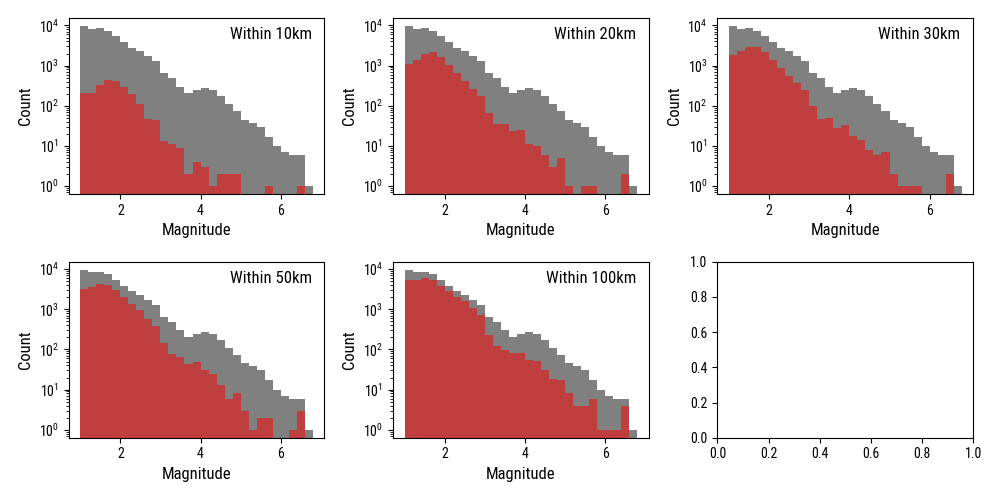

In [34]:
# Magnitude of completeness for each distance

fig, axes = plt.subplots(2, 3, figsize=(10, 5))

for ii in range(6):
    if ii == 5: continue
    ax = axes[ii//3, ii%3]
    ax.set_xlabel('Magnitude')
    ax.set_ylabel('Count')
    ax.set_yscale('log')
    ax.text(.95, .95, 'Within {:d}km'.format(distances[ii]), va='top', ha='right', transform=ax.transAxes)

    ax.hist(eq.mag.values, bins=np.arange(1, 7, .2), fc='gray', ec='none')
    ax.hist(eq.mag[(eq.mag > 1) & (eq.dist2trm < distances[ii])].values, bins=np.arange(1, 7, .2), fc=to_rgba('r', .5), ec='none')

plt.tight_layout()
plt.show()

In [41]:
# Which distance/minimum magnitude for maps
min_mag = 2.2

/var/folders/_0/w1st1dg91_l80my3nlzkvb_w0000gn/T/ipykernel_23551/3495964205.py:41: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


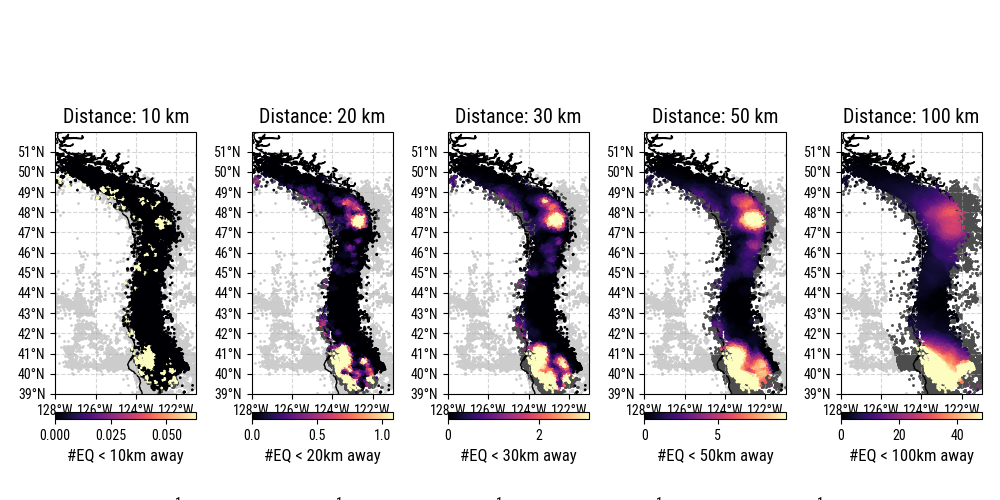

In [42]:
# Maps
lon_min = minlon
lon_max = maxlon
lat_min = minlat
lat_max = maxlat
crs = ccrs.PlateCarree()

fig = plt.figure(figsize=(10, 5))
axes = [plt.subplot(1, 5, ii+1, projection=crs) for ii in range(5)]

for ii, ax in zip(range(len(distances)), axes):
    ax.set_title('Distance: {:d} km'.format(distances[ii]))
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=crs)
    ax.coastlines(lw=1)

    # Plot tremor
    sc = ax.scatter(trm.lon, trm.lat, c=trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], s=1, cmap='magma', transform=crs, vmin=0, vmax=np.percentile(trm['m{:.1f}in{:d}km'.format(min_mag, distances[ii])], 95), zorder=2, label='Tremor')
    ax.scatter(eq[eq.dist2trm < distances[ii]].lon, eq[eq.dist2trm < distances[ii]].lat, c='.3', s=1, transform=crs, zorder=1, label='Earthquakes in range'.format(distances[ii]))
    ax.scatter(eq.lon, eq.lat, c='.8', s=1, transform=crs, zorder=0, label='All earthquakes')

    # Colorbar
    x_min_ax = 0.5; y_min_ax = -0.2
    w_ax = 0.45; h_ax = 0.05
    x_max_ax = x_min_ax + w_ax; y_max_ax = y_min_ax + h_ax

    x_min_fig, y_min_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_min_ax, y_min_ax]))
    x_max_fig, y_max_fig = fig.transFigure.inverted().transform(ax.transAxes.transform([x_max_ax, y_max_ax]))
    h_fig = y_max_fig - y_min_fig
    w_fig = x_max_fig - x_min_fig

    cb = fig.add_axes([x_min_fig, y_min_fig, w_fig, h_fig])
    cbar = plt.colorbar(sc, orientation='horizontal', label="#EQ < {:d}km away".format(distances[ii]), fraction=0.15, pad=0.04)

    # grid and labels, only bottom and left, not top and right
    ax.set_xticks(np.arange(np.ceil(lon_min), lon_max+1, 2), crs=crs)
    ax.set_yticks(np.arange(np.ceil(lat_min), lat_max, 1), crs=crs)
    ax.xaxis.set_major_formatter(LongitudeFormatter())
    ax.yaxis.set_major_formatter(LatitudeFormatter())
    ax.grid('on', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()